## Vehicle Detection and Tracking Project

The goals / steps of this project are the following:

* Use color transforms, gradients, etc., to create a thresholded binary image.
* Detect vehicles on road.
* Output visual display of the detected cars.

---
## Python Imports

In [4]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import zipfile
from scipy.ndimage.measurements import label


from skimage.feature import hog
from skimage import data, exposure
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV


## Extracta data from vehicles.zip and non-vehicles.zip

In [6]:
# verify if data directory exists, if there is not, create it from files datafiles vehicles.zip and non-vehicles.zip

if not os.path.isfile('data' + os.sep + 'vehicles' + os.sep + 'GTI_MiddleClose' + os.sep + 'image0003.png'):
    zip_ref = zipfile.ZipFile('data' + os.sep + 'vehicles.zip', 'r')
    zip_ref.extractall('data')
    zip_ref.close()
if not os.path.isfile('data' + os.sep + 'non-vehicles' + os.sep + 'GTI' + os.sep + 'image1.png'):
    zip_ref = zipfile.ZipFile('data' + os.sep + 'non-vehicles.zip', 'r')
    zip_ref.extractall('data')
    zip_ref.close()

## draw_boxes function

In [7]:
# draw boxes on image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    for (x1,y1),(x2,y2) in bboxes:
        cv2.rectangle(draw_img, (x1, y1), (x2, y2), color, thick)
    return draw_img 

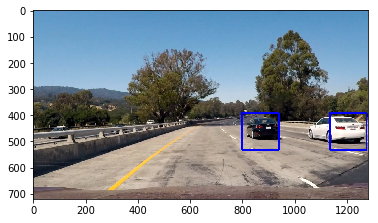

In [8]:
image = mpimg.imread('test_images/test1.jpg')
box1 = ((798, 392), (938, 532))
box2 = ((1134, 392), (1274, 532))
image = draw_boxes(image, [box1, box2])
fig = plt.figure()
plt.imshow(image)

## Extract hog features from gray image

In [9]:
# Define a function to return HOG features and visualization
# Features will always be the first element of the return
# Image data will be returned as the second element if visualize= True
# Otherwise there is no second return element
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True, show_hog = False):
                         
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    if show_hog:
        return_list = hog(img, orientations=9, pixels_per_cell=(16, 16),
                                      cells_per_block=(2, 2),
                                      block_norm= 'L2-Hys', transform_sqrt=False, 
                                      visualise= True, feature_vector=False)
        fig = plt.figure()
        plt.imshow(return_list[1])

    return return_list


Example Car


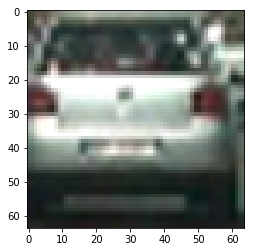

In [10]:
print ('Example Car')
image = mpimg.imread('data/vehicles/GTI_MiddleClose/image0100.png')
fig = plt.figure()
plt.imshow(image)



Hog Visualization


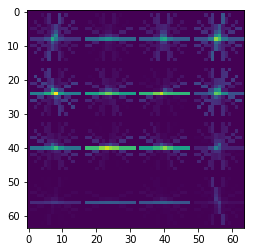

In [11]:
print ('Hog Visualization')
feature_image = np.copy(image)
gray = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
hog_features = get_hog_features(gray, orient=9, pix_per_cell=16, cell_per_block=2, vis=False, feature_vec=False, show_hog=True)


In [12]:
# Define a function to extract features from a list of images
# for each image do:
#    convert to grayscale
#    compute hog features (default parameters: orientation = 9, pixel per block = 16 and cell per block = 2)
#    append to result list
def extract_features(imgs, orient=9, pix_per_cell=16, cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    for image in imgs:
        if isinstance(image, str):
            image = mpimg.imread(image)
        hog_features = []
        feature_image = np.copy(image)
        feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
        hog_features.append(get_hog_features(feature_image[:,:], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
        features.append(hog_features)
    return features



In [13]:
features = extract_features(['./data/vehicles/GTI_MiddleClose/image0100.png'])
print ('features', features[0].shape, features)

features (324,) [array([0.29030032, 0.14637741, 0.16167668, 0.13886553, 0.24775555,
       0.08615499, 0.09254924, 0.06025342, 0.16372523, 0.05791912,
       0.02412602, 0.01588942, 0.14087528, 0.30825717, 0.1033144 ,
       0.04116886, 0.02688365, 0.0451087 , 0.05705476, 0.08914813,
       0.10510951, 0.28983154, 0.30825717, 0.20841174, 0.30825717,
       0.17649058, 0.23881424, 0.0501651 , 0.05708067, 0.07133388,
       0.18035495, 0.30825717, 0.1645987 , 0.01565907, 0.0867569 ,
       0.07544834, 0.06665416, 0.02776457, 0.01828578, 0.16212131,
       0.38971466, 0.1188957 , 0.04737771, 0.03093809, 0.05191174,
       0.19702423, 0.11442549, 0.08950605, 0.08291347, 0.38971466,
       0.14892006, 0.08982119, 0.1450289 , 0.17150732, 0.05773072,
       0.06568925, 0.08209206, 0.20755509, 0.38971466, 0.18942256,
       0.01802069, 0.09984109, 0.08682704, 0.06206025, 0.05211853,
       0.08879504, 0.25296282, 0.38971466, 0.04216827, 0.01554263,
       0.03762106, 0.00884642, 0.14916058, 0.

## Build dataset from data folder

In [14]:
# build dataset images and return car_filelist and notcar_filelist from given directory
# assumes that there is a vehicles folder with car images and non-vehicles forder with other images
def get_dataset(directory):
    car_filelist = []
    notcar_filelist = []
    
    for path, subdirs, files in os.walk(directory):
        for name in files:
            if name.endswith('.png'):
                if (os.sep + 'vehicles' + os.sep ) in path:
                    car_filelist.append(path + os.sep + name)
                if (os.sep + 'non-vehicles' + os.sep ) in path:
                    notcar_filelist.append(path + os.sep + name)

    return car_filelist, notcar_filelist


In [15]:
# show image dataset
car_filelist, notcar_filelist = get_dataset('./data')
print ('car_filelist[:10]')
print (car_filelist[:10])
print ()
print ('notcar_filelist[:10]')
print (notcar_filelist[:10])

car_filelist[:10]
['./data/__MACOSX/vehicles/GTI_Far/._image0232.png', './data/__MACOSX/vehicles/GTI_Far/._image0953.png', './data/__MACOSX/vehicles/GTI_Far/._image0822.png', './data/__MACOSX/vehicles/GTI_Far/._image0612.png', './data/__MACOSX/vehicles/GTI_Far/._image0656.png', './data/__MACOSX/vehicles/GTI_Far/._image0262.png', './data/__MACOSX/vehicles/GTI_Far/._image0283.png', './data/__MACOSX/vehicles/GTI_Far/._image0787.png', './data/__MACOSX/vehicles/GTI_Far/._image0266.png', './data/__MACOSX/vehicles/GTI_Far/._image0708.png']

notcar_filelist[:10]
['./data/non-vehicles/Extras/extra1381.png', './data/non-vehicles/Extras/extra383.png', './data/non-vehicles/Extras/extra308.png', './data/non-vehicles/Extras/extra2884.png', './data/non-vehicles/Extras/extra1396.png', './data/non-vehicles/Extras/extra61.png', './data/non-vehicles/Extras/extra4499.png', './data/non-vehicles/Extras/extra2288.png', './data/non-vehicles/Extras/extra3992.png', './data/non-vehicles/Extras/extra4833.png']


In [16]:
# build dataset 

X, y, mean, scale = None, None, None, None

X_train, X_test, y_train, y_test = None,  None,  None,  None

# if there is a dataset.npz file with previous computed dataset, use it
if os.path.isfile('dataset.npz'):
    print('dataset.npz exists')
    X_scaler = preprocessing.StandardScaler()
    dataset = np.load('dataset.npz')
    X, y, X_scaler.mean_ , X_scaler.scale_  = dataset['X'],  dataset['y'], dataset['mean'], dataset['scale']
# it there is not, create it
else:
    print('dataset.npz new')
    car_features    = extract_features(car_filelist)
    notcar_features = extract_features(notcar_filelist)
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    y_car = np.ones((len(car_filelist)))
    y_notcar = np.zeros((len(notcar_filelist)))
    y = np.hstack((y_car, y_notcar)).astype(np.int)
    X_scaler = preprocessing.StandardScaler().fit(X)
    X = X_scaler.transform(X)
    # save dataset on file dataset.npz 
    np.savez_compressed('dataset.npz', X = X, y = y, mean = X_scaler.mean_, scale = X_scaler.scale_)


dataset.npz exists


## Split dataset

In [17]:
# split dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=452553)
print ('X_train.shape', X_train.shape)
print ('y_train.shape', y_train.shape)
print ('X_test.shape', X_test.shape)
print ('y_test.shape', y_test.shape)


X_train.shape (14208, 324)
y_train.shape (14208,)
X_test.shape (3552, 324)
y_test.shape (3552,)


## Train SVM (RBF) Model

In [18]:
# train the SVM with 'rfb' model to classify car images

model = None
# if there is not a previous trained model, compute it 
if not os.path.isfile('model.pkl'):
    C = 0.200            # the best C value in `manual` searching
    gamma = 0.01         # the best gamma value in `manual` searching
    print ('C', C, 'gamma', gamma)
    model = svm.SVC(kernel='rbf', C=C, gamma=gamma)
    model.fit(X_train, y_train)
    # save trained model
    joblib.dump(model, 'model.pkl') 
# it there is a previous model, use it
else:
    model = joblib.load('model.pkl') 

print ('score in train dataset')
print (model.score(X_train, y_train))
y_train_pred = model.predict(X_train)
print ('confusion matrix in train dataset')
print (confusion_matrix(y_train, y_train_pred))
print ()
print ('score in test dataset')
print (model.score(X_test, y_test))
y_test_pred = model.predict(X_test)
print ('confusion matrix in test dataset')
print (confusion_matrix(y_test, y_test_pred))


score in train dataset
0.9827561936936937
confusion matrix in train dataset
[[7177    9]
 [ 236 6786]]

score in test dataset
0.9676238738738738
confusion matrix in test dataset
[[1772   10]
 [ 105 1665]]


## Test model in some images

Prediction [1]


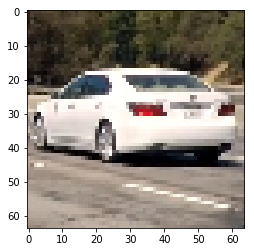

In [19]:
# Verify if trained model works with some "real" images.
L = 230
S = 64
image = mpimg.imread('test_images/test1.jpg')
ii = cv2.resize(image[344:344+L,1048:1048+L], (64, 64)) 
ii = ii.astype(np.float32) / 255.0
fig = plt.figure()
plt.imshow(ii)
image_features = extract_features([ii])
image_features = X_scaler.transform(image_features)
p = model.predict(image_features)
print ('Prediction', p)

Prediction [1]


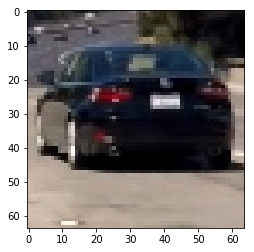

In [20]:
L = 140
S = 64
image = mpimg.imread('test_images/test1.jpg')
ii = cv2.resize(image[390:390+L,810:810+L], (S, S))   
ii = ii.astype(np.float32) / 255.0
fig = plt.figure()
plt.imshow(ii)
image_features = extract_features([ii])
image_features = X_scaler.transform(image_features)
p = model.predict(image_features)
print ('Prediction', p)

Prediction [0]


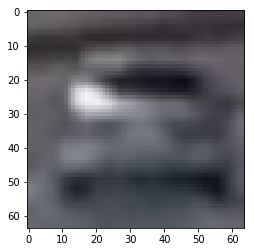

In [21]:
L = 20
S = 64
image = mpimg.imread('test_images/test1.jpg')
ii = cv2.resize(image[407:407+L,774:774+L], (S, S))   
ii = ii.astype(np.float32) / 255.0
fig = plt.figure()
plt.imshow(ii)
image_features = extract_features([ii])
image_features = X_scaler.transform(image_features)
p = model.predict(image_features)
print ('Prediction', p)

## slide_window function

In [22]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [23]:
# Verify if slide_window is working

L = 140
S = 64
window_list = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[350, 650], xy_window=(L, L), xy_overlap=(0.7, 0.7)) 
box_detected = []

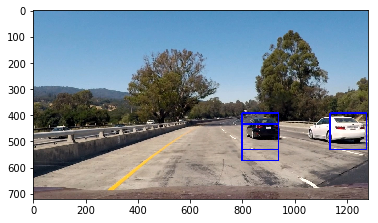

In [24]:
image = mpimg.imread('test_images/test1.jpg')

for window in window_list:
    ii = cv2.resize(image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (S, S))      
    ii = ii.astype(np.float32) / 255.0
    image_features = extract_features([ii])
    image_features = X_scaler.transform(image_features)
    p = model.predict(image_features)
    if p[0] == 1:
        box_detected.append(window)
        image =  draw_boxes(image, bboxes=[window], color=(0, 0, 255), thick=3)

fig = plt.figure()
plt.imshow(image)


## Functions to avoid false positive

In [25]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [26]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [27]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 3)
    # Return the image
    return img

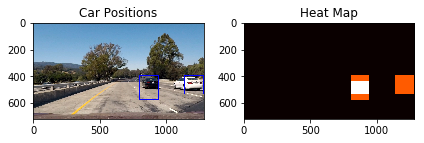

In [28]:
# Verify if pipeline add_head --> apply_threshold --> draw_labeled_bboxes is working
heat = np.zeros_like(image[:,:,0]).astype(np.float)
heat = add_heat(heat,box_detected)
heat = apply_threshold(heat,0)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Pipeline

In [29]:
# pipeline is the function that, for each image frame from video, try to detect vehicles and draw boxes

# store the last 10 boxes detected to compute an "average" and avoid false positives
N = 10                    
# the last boxes detected
box_detected_hist = []    

def pipeline(img):
    global box_detected_hist
    # all patch are resized to 64 x 64 pixeles and fill SVM model
    S = 64                
    box_detected = []
    # L is patch size, try 70x70 pixels, 100x100, 130x130, ...
    for L in [70, 100, 130, 160, 190, 220]: 
        # first, compute all sliding window for a given L
        window_list = slide_window(img,  x_start_stop=[0, 1280], y_start_stop=[350, 650], xy_window=(L, L), xy_overlap=(0.85, 0.85)) 
        for window in window_list:
            # crop window from original image and resize it to 64x64 pixels
            ii = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (S, S))      
            ii = ii.astype(np.float32) / 255.0
            image_features = extract_features([ii])
            image_features = X_scaler.transform(image_features)
            # call SVM to predict if windowed image is a vehicle
            p = model.predict(image_features)
            if p[0] == 1:
                box_detected.append(window)

    box_detected_hist.insert(0, box_detected)
    if (len(box_detected_hist) > N):
        del box_detected_hist[-1]
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    box_detected = []
    for b in box_detected_hist:
        for bb in b:
            box_detected.append(bb)
            
    heat = add_heat(heat,box_detected)
    heat = apply_threshold(heat,70)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(img, labels)
        
    return cv2.addWeighted(img, 0.8, draw_img, 1., 0.)



## Video

In [ ]:
make_video = True
if make_video:
    white_output = 'output'  + os.sep + 'project_video.mp4'
    clip = VideoFileClip("project_video.mp4")
    white_clip = clip.fl_image(pipeline) 
    %time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output/project_video.mp4
[MoviePy] Writing video output/project_video.mp4


 59%|█████▉    | 741/1261 [3:02:47<2:08:16, 14.80s/it]